In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sympy import integrate, exp, sin, log, oo, pi,symbols
import deepxde as dde
import scipy.io as scio
from mpl_toolkits.mplot3d import Axes3D
from deepxde.backend import tf
import datetime
import time
import os
from pylab import mpl
from scipy.signal import chirp, spectrogram
mpl.rcParams['font.sans-serif']=['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus']=False
from matplotlib.pyplot import MultipleLocator
import xlrd
import xlwt
from sympy import *
import sympy as sp

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
 
from matplotlib import rcParams
 
config = {
            "font.family": 'serif',
            "font.size": 6,
            "mathtext.fontset": 'stix',
            "font.serif": ['MicroSoft YaHei'],
         }
rcParams.update(config)

In [3]:
K = 1234
np.random.seed(K)
tf.set_random_seed(K)

s0 = tf.Variable(-0.1, trainable=False, dtype=tf.float32)
s1 = tf.Variable(0.5, trainable=False, dtype=tf.float32)
s2 = tf.Variable(1.1, trainable=False, dtype=tf.float32)
SS = [s0,s1,s2]

num_NN = 2

anchors_x = np.vstack((np.random.uniform(0,1,200)*0+0.5, np.random.uniform(0,1,200))).T

In [4]:
import numpy as np

def extract_uniform_grid(data, grid_size):
    x_data = data[:, 0]
    y_data = data[:, 1]
    value_data = data[:, 2]

    x_min, x_max = np.min(x_data), np.max(x_data)
    y_min, y_max = np.min(y_data), np.max(y_data)

    x_lin = np.linspace(x_min, x_max, grid_size + 2)[1:-1]
    y_lin = np.linspace(y_min, y_max, grid_size + 2)[1:-1]
    x_grid, y_grid = np.meshgrid(x_lin, y_lin)

    value_grid = np.empty_like(x_grid)

    # 为每个网格点找到最近的数据点的值
    for i in range(grid_size):
        for j in range(grid_size):
            x = x_grid[i, j]
            y = y_grid[i, j]
            # 计算所有数据点到当前网格点的距离
            distances = np.sqrt((x_data - x)**2 + (y_data - y)**2)
            # 找到最近的数据点的索引
            nearest_index = np.argmin(distances)
            # 获取最近数据点的值
            value_grid[i, j] = value_data[nearest_index]

    # 将网格数据展开为一维数组
    grid_points = np.hstack((x_grid.reshape(-1, 1), y_grid.reshape(-1, 1), value_grid.reshape(-1, 1)))

    # 根据 x 值将数据分为两组
    mask = 2*grid_points[:, 0]-grid_points[:, 1] > 0.5
    data_above_0_5 = grid_points[mask]
    data_below_or_equal_0_5 = grid_points[~mask]

    return data_below_or_equal_0_5, data_above_0_5

data_comsol = np.genfromtxt("Poisson_Damage2.txt", comments="%")
Data_value0, Data_value1 = extract_uniform_grid(data_comsol, grid_size=9)

ob_x0,ob_y0 = Data_value0[:,0:2],-Data_value0[:,2:3]
observe_u0 = dde.PointSetBC(ob_x0,ob_y0,component=0)

ob_x1,ob_y1 = Data_value1[:,0:2],-Data_value1[:,2:3]
observe_u1 = dde.PointSetBC(ob_x1,ob_y1,component=1)

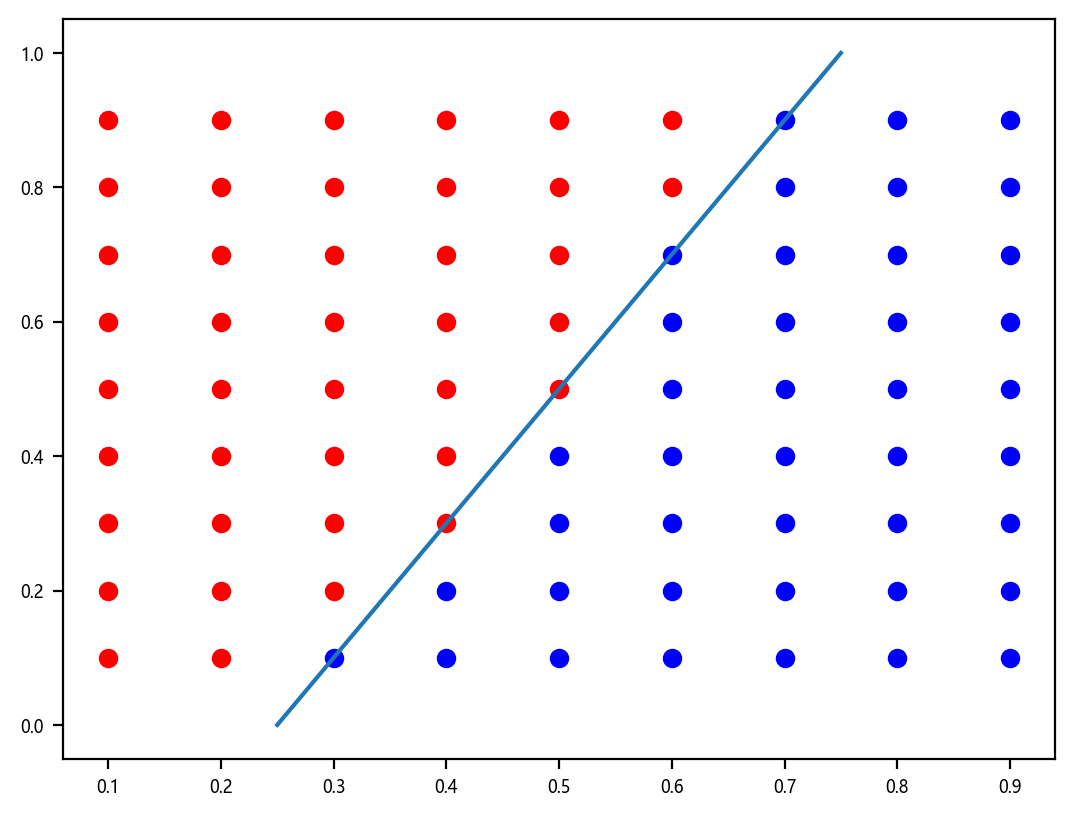

In [5]:
plt.scatter(ob_x0[:,0:1],ob_x0[:,1:2],c='red')
plt.scatter(ob_x1[:,0:1],ob_x1[:,1:2],c='blue')
x = np.linspace(0.25,0.75,100)
y = 2*x-0.5
plt.plot(x, y)

In [6]:
def Parameter_C(x_in,y_in):
    cond1 = tf.greater(2*x_in-y_in, 0.5)
    f1 = tf.ones_like(x_in) * 2
    f2 = tf.ones_like(x_in) * 1
    return tf.where(cond1, f1, f2)

def Parameter_C_NP(x_in,y_in):
    cond1 = np.greater(2*x_in-y_in, 0.5)
    f1 = np.ones_like(x_in) * 2
    f2 = np.ones_like(x_in) * 1
    return np.where(cond1, f1, f2)

def f_sig0(x_in,y_in,i):
    if i == 0:
        cond1 = tf.less_equal(2*x_in-y_in, 0.5)
        f1 = tf.ones_like(x_in)
        f2 = tf.zeros_like(x_in)
        f = tf.where(cond1, f1, f2)
        return f
    if i == 1:
        cond1 = tf.greater(2*x_in-y_in, 0.5)
        f1 = tf.ones_like(x_in)
        f2 = tf.zeros_like(x_in)
        f = tf.where(cond1, f1, f2)
        return f

C1_unkown = (tf.Variable(0.5, trainable=True, dtype=tf.float32))
C2_unkown = (tf.Variable(0.5, trainable=True, dtype=tf.float32))
C_list = [C1_unkown, C2_unkown]

def PDE(x, y):
    x_in = x[:,0:1]
    y_in = x[:,1:2]
    U    = y[:,num_NN*0:num_NN*1]
    U_x  = y[:,num_NN*1:num_NN*2]
    U_y  = y[:,num_NN*2:num_NN*3]

    U_x_dNN = []
    U_y_dNN = []
    U_xx_dNN = []
    U_yy_dNN = []
    
    for i in range(num_NN):
        u_x_dNN  = C_list[i] * dde.grad.jacobian(U, x, i = i, j=0)
        u_y_dNN  = C_list[i] * dde.grad.jacobian(U, x, i = i, j=1)
        u_xx_dNN = dde.grad.jacobian(U_x, x, i = i, j=0)
        u_yy_dNN = dde.grad.jacobian(U_y, x, i = i, j=1)

        U_x_dNN.append(u_x_dNN)
        U_y_dNN.append(u_y_dNN)
        U_xx_dNN.append(u_xx_dNN)
        U_yy_dNN.append(u_yy_dNN)

    loss_U_x = 0
    loss_U_y = 0
    loss_U_xx = 0
    loss_U_yy = 0
    loss_Source_term = 0
    for i in range(num_NN):
        loss_U_x = loss_U_x + (U_x[:,i:i+1] - U_x_dNN[i]) * f_sig0(x_in, y_in, i)
        loss_U_y = loss_U_y + (U_y[:,i:i+1] - U_y_dNN[i]) * f_sig0(x_in, y_in, i)
        loss_Source_term = loss_Source_term + (U_xx_dNN[i] + U_yy_dNN[i] - 1) * f_sig0(x_in,y_in,i)
        
    return [loss_U_x,\
            loss_U_y,\
            loss_Source_term]

geom = dde.geometry.Rectangle([0, 0], [1, 1])

data = dde.data.TimePDE(geom,PDE,[observe_u0, observe_u1], num_domain=2000)

net = dde.maps.FNN([2]  + [50]*3 + [num_NN*3], "tanh", "Glorot uniform")

def modify_output(X, y):
    x0 = X[:,0:1]
    x1 = X[:,1:2]
    U    =    y[:, num_NN*0:num_NN*1]
    U_x  =    y[:, num_NN*1:num_NN*2]
    U_y  =    y[:, num_NN*2:num_NN*3]
    Hard_BC = y[:, num_NN*3:num_NN*3+1]

    Hard_BC = tf.layers.dense(2*x0-x1-0.5, 20, "tanh")  
    for i in range(2):
        Hard_BC = tf.layers.dense(Hard_BC, 20, "tanh")
    Hard_BC = tf.layers.dense(Hard_BC, 1, None)
    
    final_output = tf.concat([0.01 * ((2*x0-x1-0.5)*U[:,0:1]+Hard_BC)*x0*(x0-1)*x1*(x1-1),\
                              0.01 * ((2*x0-x1-0.5)*U[:,1:2]+Hard_BC)*x0*(x0-1)*x1*(x1-1),\
                              U_x[:,0:1]*x1*(x1-1),\
                              U_x[:,1:2]*x1*(x1-1),\
                              U_y[:,0:1]*x0,\
                              U_y[:,1:2]*(x0-1),\
                             ], axis=1)
    return final_output

net.apply_output_transform(modify_output)
model = dde.Model(data, net)

loss = []
for i in range(5):
    loss.append('MAE')

variable = dde.callbacks.VariableValue([C1_unkown,C2_unkown], period=200, filename="C.dat")

model.compile("adam", 1e-3, loss_weights=[1, 1, 1, 1, 1], loss = loss)
losshistory, train_state = model.train(epochs=20000, callbacks=[variable])
# dde.saveplot(losshistory, train_state, issave=False, isplot=True)
list_point = []

Compiling model...
Building feed-forward neural network...
'build' took 0.048478 s



/home/pms/anaconda3/envs/tensorflow/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/tmp/ipykernel_11621/2647252120.py:82: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Hard_BC = tf.layers.dense(2*x0-x1-0.5, 20, "tanh")
/tmp/ipykernel_11621/2647252120.py:84: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Hard_BC = tf.layers.dense(Hard_BC, 20, "tanh")
/tmp/ipykernel_11621/2647252120.py:85: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Hard_BC = tf.layers.dense(Hard_BC, 1, None)
2025-04-08 14:58:23.437859: I tensorflow/core/platform/cpu_feature_guard.cc:193] 

'compile' took 2.395921 s

Training model...



2025-04-08 14:58:25.825275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-04-08 14:58:25.931356: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7fad2c021ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-08 14:58:25.931381: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-04-08 14:58:25.941965: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-04-08 14:58:25.941979: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-04-08 14:58:25.942101: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-08 14:58:26.206882: I tensorflow/compiler/mlir/tensorflow/util

Step      Train loss                                            Test loss                                             Test metric
0         [5.28e-02, 1.07e-01, 1.06e+00, 3.42e-02, 2.51e-02]    [5.28e-02, 1.07e-01, 1.06e+00, 3.42e-02, 2.51e-02]    []  
1000      [1.07e-02, 1.13e-02, 3.28e-02, 1.87e-02, 1.00e-02]    [1.07e-02, 1.13e-02, 3.28e-02, 1.87e-02, 1.00e-02]    []  
2000      [8.63e-03, 1.04e-02, 1.42e-02, 1.37e-02, 6.19e-03]    [8.63e-03, 1.04e-02, 1.42e-02, 1.37e-02, 6.19e-03]    []  
3000      [7.61e-03, 1.00e-02, 9.03e-03, 6.46e-03, 3.64e-03]    [7.61e-03, 1.00e-02, 9.03e-03, 6.46e-03, 3.64e-03]    []  
4000      [7.07e-03, 9.42e-03, 6.88e-03, 3.08e-03, 2.56e-03]    [7.07e-03, 9.42e-03, 6.88e-03, 3.08e-03, 2.56e-03]    []  
5000      [6.62e-03, 8.77e-03, 5.70e-03, 2.09e-03, 2.07e-03]    [6.62e-03, 8.77e-03, 5.70e-03, 2.09e-03, 2.07e-03]    []  
6000      [6.65e-03, 8.15e-03, 7.40e-03, 1.55e-03, 1.74e-03]    [6.65e-03, 8.15e-03, 7.40e-03, 1.55e-03, 1.74e-03]    []  
7000     

In [7]:
model.compile("adam", 1e-4, loss_weights=[1, 1, 1, 1, 1], loss = loss)
losshistory, train_state = model.train(epochs=30000, callbacks=[variable])

Compiling model...
'compile' took 2.516634 s



2025-04-08 14:59:06.994256: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                            Test loss                                             Test metric
20000     [2.63e-03, 3.73e-03, 6.81e-03, 5.11e-04, 4.49e-04]    [2.63e-03, 3.73e-03, 6.81e-03, 5.11e-04, 4.49e-04]    []  
21000     [2.41e-03, 3.46e-03, 1.84e-03, 5.14e-04, 4.57e-04]    [2.41e-03, 3.46e-03, 1.84e-03, 5.14e-04, 4.57e-04]    []  
22000     [2.36e-03, 3.42e-03, 1.68e-03, 5.08e-04, 4.57e-04]    [2.36e-03, 3.42e-03, 1.68e-03, 5.08e-04, 4.57e-04]    []  
23000     [2.31e-03, 3.37e-03, 1.59e-03, 5.01e-04, 4.56e-04]    [2.31e-03, 3.37e-03, 1.59e-03, 5.01e-04, 4.56e-04]    []  
24000     [2.27e-03, 3.31e-03, 1.53e-03, 4.93e-04, 4.53e-04]    [2.27e-03, 3.31e-03, 1.53e-03, 4.93e-04, 4.53e-04]    []  
25000     [2.23e-03, 3.27e-03, 1.48e-03, 4.85e-04, 4.50e-04]    [2.23e-03, 3.27e-03, 1.48e-03, 4.85e-04, 4.50e-04]    []  
26000     [2.19e-03, 3.22e-03, 1.45e-03, 4.78e-04, 4.49e-04]    [2.19e-03, 3.22e-03, 1.45e-03, 4.78e-04, 4.49e-04

<Figure size 640x480 with 0 Axes>

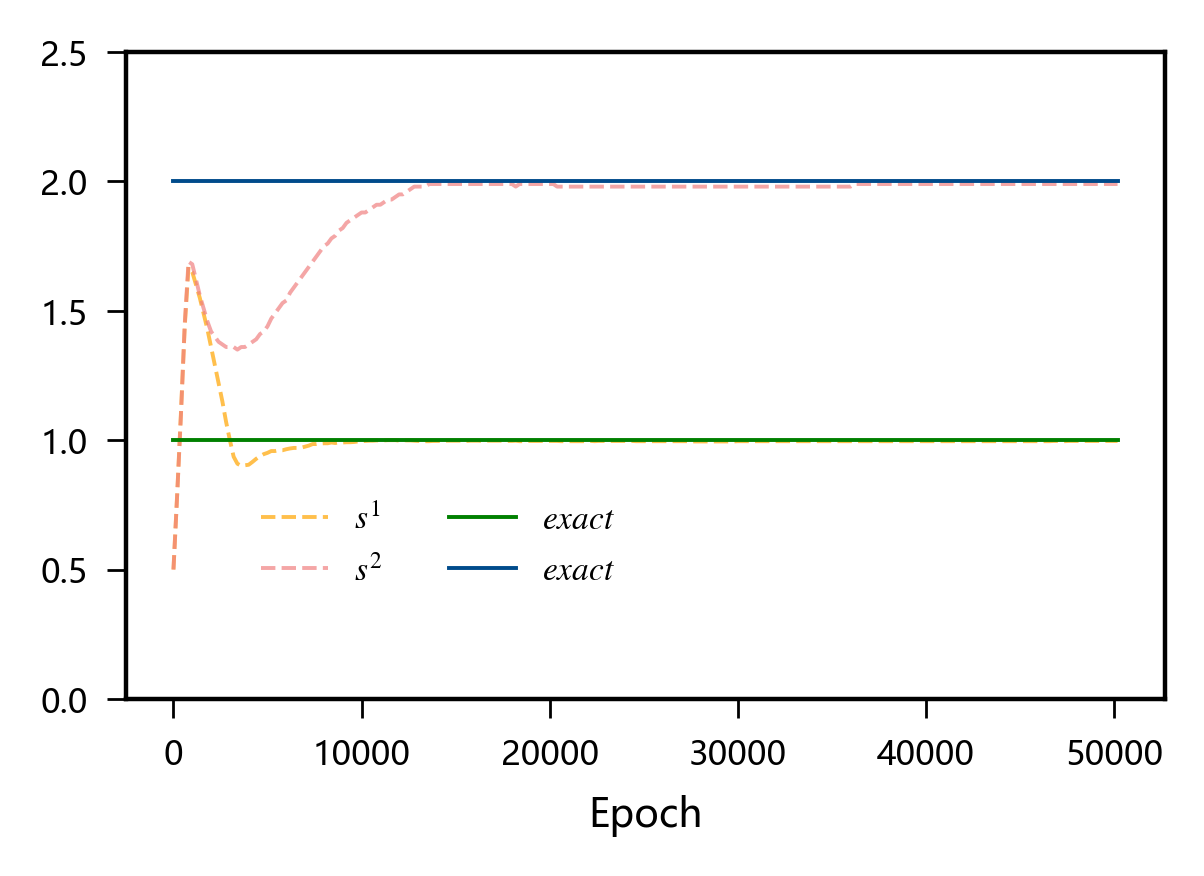

[0.997 1.99 ]


In [8]:
import re
lines = open("C.dat", "r").readlines()
S = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
markersize = 10
markevery = 50
plt.figure()
l = S.shape[0]
width, height, dpi = 3.35, 2.1, 200
plt.figure(figsize=(width,height),dpi = dpi)
markersize = 2
markevery = 20
plt.plot(range(0, 200 * l, 200), S[:,0:1], linestyle='dashed',alpha=0.7,linewidth=0.7, \
        label="$s^1$",color='orange')
plt.plot(range(0, 200 * l, 200), S[:,1:2], linestyle='dashed',alpha=0.7,linewidth=0.7, \
         label="$s^2$",color='lightcoral')
plt.plot(range(0, 200 * l, 200), S[:,0:1]*0+1,linewidth=0.7, label="$exact$",color='green')
plt.plot(range(0, 200 * l, 200), S[:,0:1]*0+2,linewidth=0.7, label="$exact$",color='#004B8B')
plt.ylim(0,2.5)
plt.tick_params(width=0.5, labelsize=6)
plt.xlabel('Epoch', fontsize=7)
plt.legend(fontsize=6,frameon=False,bbox_to_anchor=(0.5, 0.35), ncol=2)
plt.savefig('ex3_s.png',bbox_inches='tight', dpi=800)
plt.show()
data_s = np.hstack((np.array([range(0, 200 * l, 200)]).reshape(-1,1),S))
print(data_s[-1, 1:3])
c1_pre = data_s[-1, 1:2][0]
c2_pre = data_s[-1, 2:3][0]